In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.optimizers import Adam, Adagrad, SGD
from keras.utils import np_utils
from keras.callbacks import History 
import pickle
import matplotlib.pyplot as plt
import os

data_path = '/Users/mhy/Desktop/cifar-10-batches-py'
os.listdir(data_path)
history = History()

Using TensorFlow backend.


In [3]:
#function that get sepcific data file path
def get_file_path(fileName):
    return os.path.join(data_path, fileName)

#function that load data with pickle
def unpickle(file):
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding = 'bytes')
    return data
    

In [4]:
#get and load all batches from the folder and put them into array "batches"
file = get_file_path("data_batch_1")
batch_1 = unpickle(file)
file = get_file_path("data_batch_2")
batch_2 = unpickle(file)
file = get_file_path("data_batch_3")
batch_3 = unpickle(file)
file = get_file_path("data_batch_4")
batch_4 = unpickle(file)
file = get_file_path("data_batch_5")
batch_5 = unpickle(file)
file = get_file_path("test_batch")
test_batch = unpickle(file)
batches = [batch_1, batch_2, batch_3, batch_4, batch_5]

In [5]:
#get pixel data from file and put them into numpy matrices
def load_batch(batch_name):
    image_label = np.array(batch_name[b'labels'])    #get image labels
    image_data = np.array(batch_name[b'data'], float)   #get image data
    image_matrix = image_data.reshape([-1, 3, 32, 32]) #reshape matrix into 5000 of 3*32*32 matrix
    image_matrix = image_matrix.transpose(0, 2, 3, 1)
    image_matrix /= 255  #normalize data
    return (image_matrix, image_label)

In [7]:
#load batch_1, train_x is the image data matrix, train_y is image labels
train_x = load_batch(batches[0]) [0]
train_y = load_batch(batches[0]) [1]

#load batch_2 to batch_5 and append to train_x, train_y
for i in range(1,5):
    (x, y) = load_batch(batches[i])
    train_x = np.append(train_x, x, axis = 0)
    train_y = np.append(train_y, y, axis = 0)
print("train x shape: ", train_x.shape, " , train y shape: ", train_y.shape)

#load test_batch
test_x = load_batch(test_batch) [0]
test_y = load_batch(test_batch) [1]
print("test x shape: ", test_x.shape)

train_Y = np_utils.to_categorical(train_y, 10)
test_Y = np_utils.to_categorical(test_y, 10)
print("train y: ", train_Y.shape, "test y: ", test_Y.shape)

train x shape:  (50000, 32, 32, 3)  , train y shape:  (50000,)
test x shape:  (10000, 32, 32, 3)
train y:  (50000, 10) test y:  (10000, 10)


In [192]:
#Define model: 6 convolution layer, 4 maxpooling layer, 6 dropout layer, 3 dence layer, 
#one flatten layer. The last activation function is "softmax", other layer uses "relu"
model = Sequential()
model.add(Convolution2D(32, (3, 3), padding = 'same', input_shape = (32, 32, 3))) #shape to 32*32*32
model.add(Activation('relu'))
model.add(Convolution2D(32, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2), data_format="channels_last")) #shape to 16*16*32
model.add(Dropout(0.5))
model.add(Convolution2D(48, (3, 3), padding = 'same'))                  #shape to 16*16*48
model.add(Activation('relu'))
model.add(Convolution2D(48, (3, 3), padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2), data_format="channels_last")) #shape to 8*8*48
model.add(Dropout(0.5))
model.add(Convolution2D(64, (3, 3), padding = 'same'))                  #shape to 8*8*64
model.add(Activation('relu'))
#model.add(Convolution2D(64, (3, 3), padding = 'same'))
#model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2), data_format="channels_last")) #shape to 4*4*64
model.add(Dropout(0.5))
model.add(Convolution2D(128, (3, 3), padding = 'same'))                 #shape to 4*4*128
model.add(Activation('relu'))
#model.add(Convolution2D(128, (3, 3), padding = 'same'))
#model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2), data_format="channels_last")) #shape to 2*2*128
model.add(Dropout(0.5))
model.add(Flatten())                                                    #resahpe matrix into a vector
#model.add(Dense(1024))
#model.add(Activation('tanh'))
#model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_155 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
activation_213 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_156 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_214 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_125 (Dropout)        (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_157 (Conv2D)          (None, 16, 16, 48)        13872     
__________

In [196]:
#using optimizer Adam with lerning rate 0.0005
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=0.0005), metrics=['accuracy'])

In [197]:
#train model with batch size 100 and 35 epochs. Validation set is the test data.
train = model.fit(train_x, train_Y, batch_size = 100, epochs = 35, verbose = 1, validation_data = (test_x, test_Y), shuffle=True,)

Train on 50000 samples, validate on 10000 samples
Epoch 1/35
50000/50000 [==============================] - 332s - loss: 0.9724 - acc: 0.6611 - val_loss: 0.9082 - val_acc: 0.6816
Epoch 2/35
50000/50000 [==============================] - 321s - loss: 0.9555 - acc: 0.6686 - val_loss: 0.8999 - val_acc: 0.6862
Epoch 3/35
50000/50000 [==============================] - 431s - loss: 0.9535 - acc: 0.6673 - val_loss: 0.8669 - val_acc: 0.6928
Epoch 4/35
50000/50000 [==============================] - 326s - loss: 0.9491 - acc: 0.6700 - val_loss: 0.8403 - val_acc: 0.7072
Epoch 5/35
50000/50000 [==============================] - 325s - loss: 0.9440 - acc: 0.6711 - val_loss: 0.9528 - val_acc: 0.6631
Epoch 6/35
50000/50000 [==============================] - 344s - loss: 0.9378 - acc: 0.6757 - val_loss: 0.8528 - val_acc: 0.7042
Epoch 7/35
50000/50000 [==============================] - 330s - loss: 0.9275 - acc: 0.6798 - val_loss: 0.8475 - val_acc: 0.6990
Epoch 8/35
50000/50000 [=======================

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


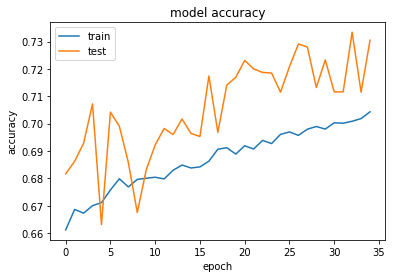

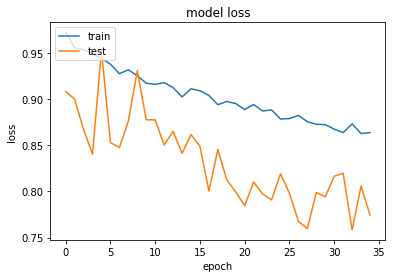

In [198]:
#draw loss graph
print(train.history.keys())
plt.plot(train.history['acc'])
plt.plot(train.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(train.history['loss'])
plt.plot(train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()